# Airbnb insights of Sevilla, Spain

In this notebook, I will be doing some analysis of the data downloaded from the Airbnb website for the spanish city of Sevilla


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Popularity of Sevilla and price variability](#Popularity-of-Sevilla-and-price-variability)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)



In [406]:
# Let's get started by importing the necessary libraries and reading in the data.
import pandas as pd
import numpy as np
from itertools import cycle, islice

import matplotlib.pyplot as plt
import seaborn as sns

#% pip install wordcloud
from wordcloud import WordCloud
import string

import nltk
import os

import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

# display setup
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('max_colwidth', 200)

In [386]:
listing = pd.read_csv('listings.csv')
review = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
neighbourhoods = pd.read_csv('neighbourhoods.csv')

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Below I will provide some insight into the descriptive statistics of the data.

`1.` Overview of the datasets

In [389]:
print('Excerpt of the \'listings\' dataset:')
listing.head(4)

Excerpt of the 'listings' dataset:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,32347,Explore Cultural Sights from a Family-Friendly Apartment,139939,Alejandro,Casco Antiguo,San Vicente,37.39468,-6.00183,Entire home/apt,99,2,168,2020-01-08,1.37,1,257
1,49287,BEAUTIFUL APARTMENT IN SEVILLE,224697,Walter,Casco Antiguo,Feria,37.39855,-5.99365,Entire home/apt,55,1,42,2020-02-17,0.35,1,302
2,94187,(2) ROOM + PRIVATE BATHROOM. CASA DEL BUEN VIAJE,503692,Margot,Casco Antiguo,San Bartolomé,37.39012,-5.98676,Private room,59,2,75,2019-06-05,0.66,6,245
3,108568,TERRACE ALAMEDA. WIFI GARAGE DOWNTOWN,589600,Miguel,Casco Antiguo,Feria,37.39939,-5.99237,Entire home/apt,65,3,81,2019-12-29,0.71,13,341


In [390]:
print('Excerpt of the \'reviews\' dataset:')
review.head(4)

Excerpt of the 'reviews' dataset:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,32347,166105,2011-01-05,177444,Peter,Great location and great host!
1,32347,238321,2011-04-25,356558,Nicholas,"excellent apartment, great location"
2,32347,508902,2011-09-06,723051,Nadine,"My parents and I had a fabulous stay in Alex's apartment. Such a great first experience of stunning Seville. Just as described the apartment is only 5 minutes walk to Sierpes, which is the main s..."
3,32347,1056439,2012-03-28,873621,Cathy,"We had a fantastic stay. Alex's apartment is beautiful; clean, uncluttered, yet homely. Alex was a great host, flexible to our timings, very generous with extra treats and very friendly. Seville..."


In [391]:
print('Excerpt of the \'calendar\' dataset:')
calendar.head(4)

Excerpt of the 'calendar' dataset:


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,879051,2021-02-01,t,$50.00,$50.00,2.0,365.0
1,32347,2021-01-31,f,$99.00,$99.00,2.0,1125.0
2,32347,2021-02-01,f,$99.00,$99.00,2.0,1125.0
3,32347,2021-02-02,f,$99.00,$99.00,2.0,1125.0


In [392]:
print('Excerpt of the \'neighbourhoods\' dataset:')
neighbourhoods.head(4)

Excerpt of the 'neighbourhoods' dataset:


,neighbourhood_group,neighbourhood
0,Casco Antiguo,Alfalfa
1,Casco Antiguo,Arenal
2,Casco Antiguo,"Encarnación, Regina"
3,Casco Antiguo,Feria


`2.` Check for columns that have missing values

In [399]:
nulls_listing = set(listing.columns[listing.isnull().mean()!=0])
print('Columns with null values in the \'listings\'dataset:', nulls_listing)

nulls_calendar = set(calendar.columns[calendar.isnull().mean()!=0])
print('Columns with null values in the \'calendar\'dataset:', nulls_calendar)

nulls_review = set(review.columns[review.isnull().mean()!=0])
print('Columns with null values in the \'reviews\'dataset:', nulls_review)

nulls_neighbourhoods = set(neighbourhoods.columns[neighbourhoods.isnull().mean()!=0])
print('Columns with null values in the \'neighbourhoods\'dataset:', nulls_neighbourhoods)

Columns with null values in the 'listings'dataset: {'last_review', 'host_name', 'reviews_per_month'}
Columns with null values in the 'calendar'dataset: {'maximum_nights', 'minimum_nights'}
Columns with null values in the 'reviews'dataset: {'comments'}
Columns with null values in the 'neighbourhoods'dataset: set()


1. Is Sevilla a popular city the whole year or is seasonal? How price and availability change?
2. How has changed the market through the years?
3. Is neighbourhood related to prices?

### <a class="anchor" id="Popularity-of-Sevilla-and-price-variability">Part II : Popularity of Sevilla and price variability</a>

The aim of this section is to find out how popular Sevilla is through the years and if it has an impact on the price

`1.` What are the most popular months?

Here I will be using the review and calendar datasets. The date column needs to be split to use it

In [408]:
# Function to split the date column
def split_date(df, column):
    df[column] =  pd.to_datetime(df[column])
    df[column+'_year'] = df[column].apply(lambda x: x.year)
    df[column+'_month'] = df[column].apply(lambda x: x.month)
    df[column+'_day'] = df[column].apply(lambda x: x.day)
    df[column+'_dayofweek'] = df[column].apply(lambda x: x.strftime('%A'))

In [144]:
split_date(review, 'date')

In [145]:
review.groupby(['date_year'])['listing_id'].count()

date_year
2011       85
2012      702
2013     2416
2014     5730
2015    13137
2016    25853
2017    43651
2018    65476
2019    94022
2020    30618
2021      892
Name: listing_id, dtype: int64

/Users/petanth/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


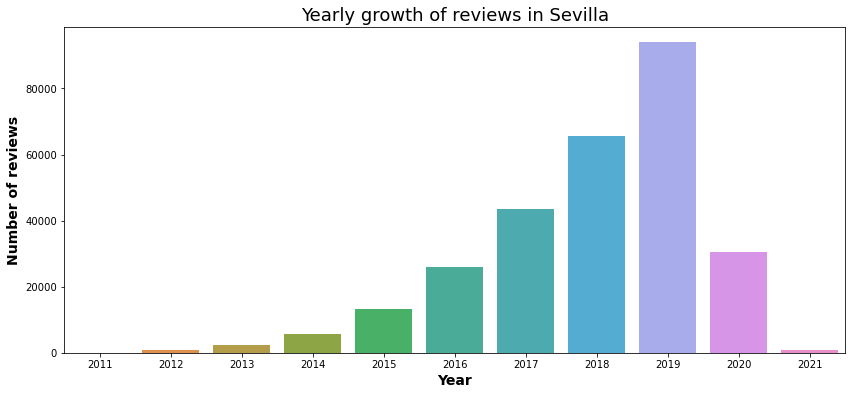

In [166]:
plt.figure(figsize = (14,6))
x = sns.countplot(review.date_year)
var = x.set_title('Yearly growth of reviews in Sevilla', fontsize=18)
var = x.set_xlabel('Year', fontsize=14, weight='bold')
var = x.set_ylabel('Number of reviews', fontsize=14, weight='bold')

Number of neighbourhoods on the dataset 11


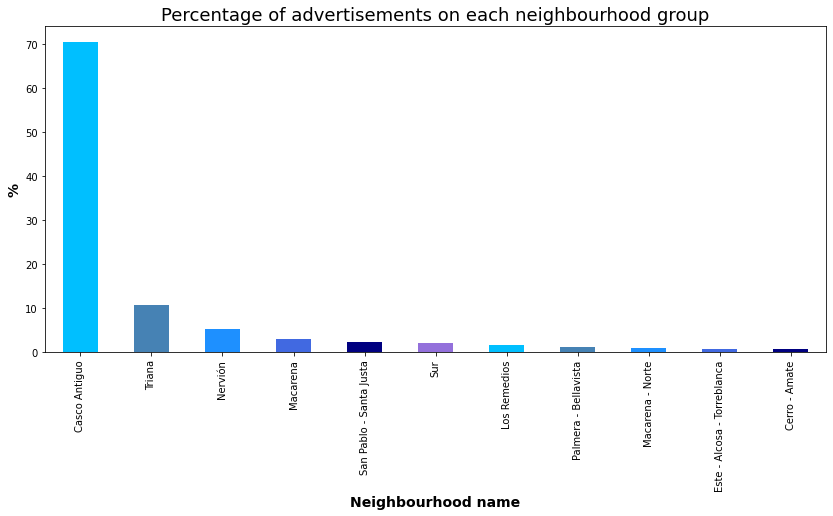

In [384]:
print('Number of neighbourhoods on the dataset', len(neighbourhoods.neighbourhood_group.unique()))

my_colors = list(islice(cycle(['deepskyblue', 'steelblue', 'dodgerblue', 'royalblue', 'navy', 'mediumpurple']), None, len((neighbourhoods.neighbourhood_group.unique()))))

status_vals = listing.neighbourhood_group.value_counts()
plt.figure(figsize = (14,6))
((status_vals/listing.shape[0])*100).plot(kind="bar", color=my_colors, stacked=True)
plt.title("Percentage of advertisements on each neighbourhood group", fontsize=18)
plt.xlabel('Neighbourhood name', fontsize=14, fontweight='bold')
plt.ylabel('%', fontsize=14, fontweight='bold')
plt.show()

In [141]:
listing.neighbourhood_group

0       Casco Antiguo
1       Casco Antiguo
2       Casco Antiguo
3       Casco Antiguo
4       Casco Antiguo
            ...      
5305    Casco Antiguo
5306    Casco Antiguo
5307    Casco Antiguo
5308    Casco Antiguo
5309         Macarena
Name: neighbourhood_group, Length: 5310, dtype: object

In [279]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,879051,2021-02-01,t,$50.00,$50.00,2.0,365.0
1,32347,2021-01-31,f,$99.00,$99.00,2.0,1125.0
2,32347,2021-02-01,f,$99.00,$99.00,2.0,1125.0
3,32347,2021-02-02,f,$99.00,$99.00,2.0,1125.0
4,32347,2021-02-03,f,$99.00,$99.00,2.0,1125.0


In [280]:
# Separate date data
split_date(calendar, 'date')

# Convert the price to int
def fixPrice(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].astype(float)
fixPrice(calendar, 'price')
fixPrice(calendar, 'adjusted_price') 

In [281]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,date_year,date_month,date_day,date_dayofweek
0,879051,2021-02-01,t,50.0,50.0,2.0,365.0,2021,2,1,Monday
1,32347,2021-01-31,f,99.0,99.0,2.0,1125.0,2021,1,31,Sunday
2,32347,2021-02-01,f,99.0,99.0,2.0,1125.0,2021,2,1,Monday
3,32347,2021-02-02,f,99.0,99.0,2.0,1125.0,2021,2,2,Tuesday
4,32347,2021-02-03,f,99.0,99.0,2.0,1125.0,2021,2,3,Wednesday


In [289]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()

<ipython-input-289-d626ab18fe58>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].describe()


price                                                   \
               count        mean          std  min   25%   50%    75%   
date_month                                                              
1           164649.0  633.757004  2010.703940  8.0  50.0  80.0  160.0   
2           148652.0  136.426432   638.345956  8.0  45.0  65.0   95.0   
3           164579.0  163.976261   679.935193  9.0  50.0  73.0  120.0   
4           159270.0  212.325560   712.280325  9.0  56.0  90.0  165.0   
5           164579.0  193.820761   790.163314  9.0  55.0  80.0  135.0   
6           159270.0  242.660036   948.197679  9.0  51.0  80.0  131.0   
7           164579.0  271.131347  1084.345969  9.0  50.0  75.0  123.0   
8           164579.0  284.547445  1144.590327  9.0  50.0  75.0  120.0   
9           159270.0  405.532134  1538.712689  9.0  51.0  80.0  146.0   
10          164579.0  416.001483  1558.505194  9.0  52.0  80.0  150.0   
11          159270.0  411.984102  1563.075682  9.0  50.0  79.0  135.0   
12          164579.0  426.656943  1590.291990  9.0  50.0  80.0  150.0   

                    adjusted_price                                            \
                max          count        mean          std  min   25%   50%   
date_month                                                                     
1           10499.0       164649.0  632.257530  2007.770396  8.0  50.0  80.0   
2           11498.0       148652.0  136.075559   637.704086  8.0  45.0  65.0   
3           11498.0       164579.0  163.517113   679.617984  9.0  50.0  73.0   
4           11498.0       159270.0  211.427187   710.536945  9.0  55.0  90.0   
5           11498.0       164579.0  192.828836   788.649816  9.0  55.0  80.0   
6           11498.0       159270.0  241.722214   946.945498  9.0  51.0  80.0   
7           10999.0       164579.0  270.393410  1083.478495  9.0  50.0  75.0   
8           10999.0       164579.0  283.767157  1143.559015  9.0  50.0  75.0   
9           10999.0       159270.0  404.591072  1537.028327  9.0  50.0  80.0   
10          10999.0       164579.0  415.310884  1556.823479  9.0  51.0  80.0   
11          10999.0       159270.0  410.996836  1561.366753  9.0  50.0  79.0   
12          10999.0       164579.0  425.853833  1588.612238  9.0  50.0  80.0   

                            
              75%      max  
date_month                  
1           160.0  10000.0  
2            94.0  11498.0  
3           120.0  11498.0  
4           164.0  11498.0  
5           135.0  11498.0  
6           130.0  11498.0  
7           122.0  10999.0  
8           120.0  10999.0  
9           145.0  10999.0  
10          150.0  10999.0  
11          135.0  10999.0  
12          150.0  10999.0

In [290]:
calendar.groupby(['date_month'])['price', 'adjusted_price'].median()

<ipython-input-290-5d5f45e1df11>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calendar.groupby(['date_month'])['price', 'adjusted_price'].median()


,price,adjusted_price
date_month,,
1,80.0,80.0
2,65.0,65.0
3,73.0,73.0
4,90.0,90.0
5,80.0,80.0
6,80.0,80.0
7,75.0,75.0
8,75.0,75.0
9,80.0,80.0


In [295]:
n_bins = np.arange(calendar.price.min()-1,calendar.price.max(),400)
n_bins
len(n_bins)

29

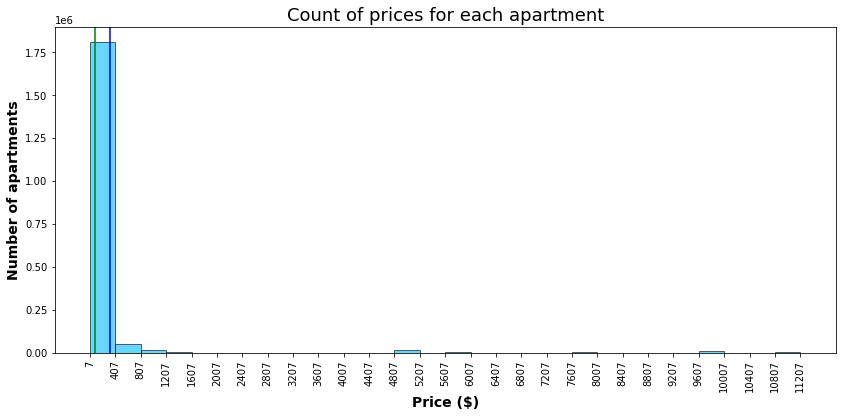

In [300]:
plt.figure(figsize = (14,6))
plt.hist(calendar.price, bins = n_bins, alpha=0.6, histtype='bar', ec='black', color = "deepskyblue");
plt.title('Count of prices for each apartment', fontsize=18)
plt.xlabel('Price ($)', fontsize=14, fontweight='bold')
plt.ylabel('Number of apartments', fontsize=14, fontweight='bold')
plt.axvline(x = calendar.price.mean(),color = 'blue')
plt.axvline(x = calendar.price.median(),color = 'green')
plt.xticks(n_bins, rotation=90)
plt.show()

In [272]:
calendar.sort_values(by='date_year', ascending=False)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,date_year,date_month,date_day,date_dayofweek
1937854,47947887,2022-01-30,t,49.0,49.0,1.0,1125.0,2022,1,30,Sunday
430343,16903143,2022-01-09,f,62.0,62.0,1.0,1125.0,2022,1,9,Sunday
430349,16903143,2022-01-15,f,70.0,70.0,1.0,1125.0,2022,1,15,Saturday
430348,16903143,2022-01-14,f,70.0,70.0,1.0,1125.0,2022,1,14,Friday
430347,16903143,2022-01-13,f,62.0,62.0,1.0,1125.0,2022,1,13,Thursday
...,...,...,...,...,...,...,...,...,...,...,...
674346,21474559,2021-03-28,f,9999.0,9999.0,1.0,1125.0,2021,3,28,Sunday
674345,21474559,2021-03-27,f,9999.0,9999.0,1.0,1125.0,2021,3,27,Saturday
674344,21474559,2021-03-26,f,9999.0,9999.0,1.0,1125.0,2021,3,26,Friday
674343,21474559,2021-03-25,f,9999.0,9999.0,1.0,1125.0,2021,3,25,Thursday


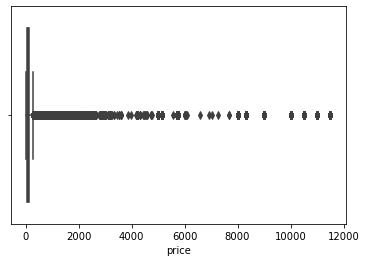

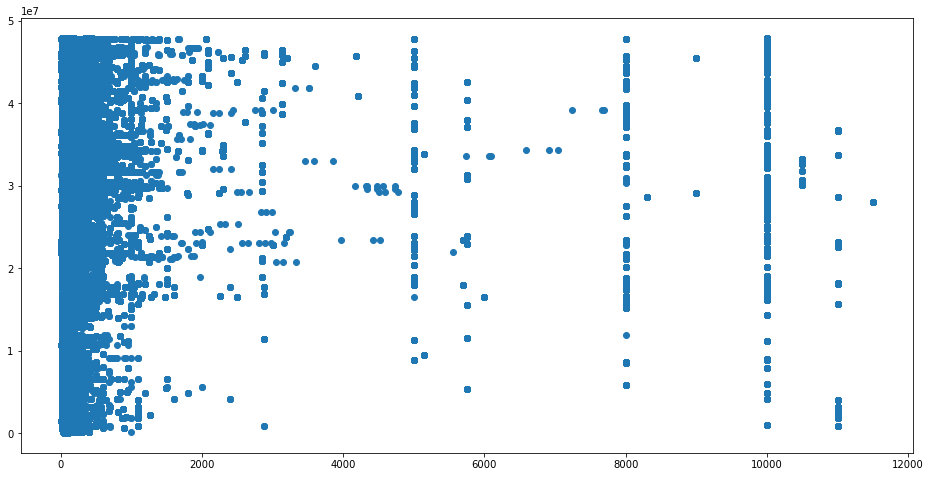

In [302]:
sns.boxplot(x=calendar['price'])

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(calendar['price'], calendar['listing_id'])

In [304]:
# Use of IQR (Interquantile Range) to detect outliers in price
Q1 = calendar.quantile(0.25)
Q3 = calendar.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

listing_id        22486959.0
price                   85.0
adjusted_price          84.0
minimum_nights           1.0
maximum_nights         625.0
date_year                0.0
date_month               6.0
date_day                15.0
dtype: float64


In [305]:
calendar.shape

(1937855, 11)

In [355]:
Q1_price = calendar.price.quantile(0.25)
Q3_price = calendar.price.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)

print(calendar.price)
print(Q1_price - 1.5 * IQR_price)
print(Q1_price + 1.5 * IQR_price)
print((calendar.price < (Q1_price - 1.5 * IQR_price)) |(calendar.price > (Q1_price + 1.5 * IQR_price)).any())

85.0
0          50.0
1          99.0
2          99.0
3          99.0
4          99.0
           ... 
1937850    49.0
1937851    49.0
1937852    49.0
1937853    49.0
1937854    49.0
Name: price, Length: 1937855, dtype: float64
-77.5
177.5
0          True
1          True
2          True
3          True
4          True
           ... 
1937850    True
1937851    True
1937852    True
1937853    True
1937854    True
Name: price, Length: 1937855, dtype: bool


In [365]:
calendar_red = calendar[['price']]
print(calendar_red.head())
print(calendar_red.shape)

Q1_price = calendar_red.quantile(0.25)
Q3_price = calendar_red.quantile(0.75)
IQR_price = Q3_price - Q1_price
print(IQR_price)
calendar_red.price.dtype
x = Q1_price - 1.5 * IQR_price
y = Q1_price + 1.5 * IQR_price
print(x)
print(y)
calendar_red.describe()

   price
0   50.0
1   99.0
2   99.0
3   99.0
4   99.0
(1937855, 1)
price    85.0
dtype: float64
price   -77.5
dtype: float64
price    177.5
dtype: float64


,price
count,1.937855e+06
mean,3.180433e+02
std,1.276477e+03
min,8.000000e+00
25%,5.000000e+01
50%,7.900000e+01
75%,1.350000e+02
max,1.149800e+04


In [369]:
calendar_red = calendar_red.sort_values(by='price')

In [372]:
print(~((calendar_red < x)|
        (calendar_red > y)))

         price
1254531   True
1264664   True
1264663   True
1254539   True
1254540   True
...        ...
954862   False
954861   False
954860   False
954930   False
954877   False

[1937855 rows x 1 columns]


In [381]:
calendar_out = calendar_red[~((calendar_red < x)|(calendar_red > y)).any(axis=1)]
print(calendar_out.shape)
print(calendar_red.shape)

(1593970, 1)
(1937855, 1)


<AxesSubplot:xlabel='price'>

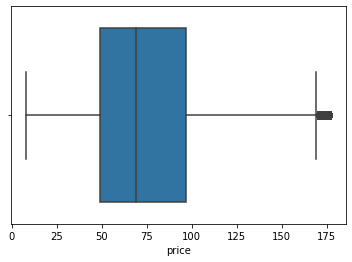

In [382]:
sns.boxplot(x=calendar_out['price'])

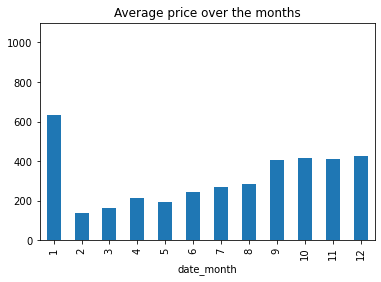

In [218]:
plt.ylim(0, 1100)
calendar.groupby(['date_month'])['price'].mean().plot(kind='bar', title = 'Average price over the months');